In [1]:
import numpy as np
import pandas as pd
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
import scorecardpy as sc
import pickle
from sklearn.pipeline import Pipeline
from data_preparation.additional_transformers import GiniSelector, OverCorrelatedDropper
from data_preparation.transform_features import remove_nans, full_pipeline_logisitic
from data_preparation.metrics_eval import evaluate_model, find_best_threshold, confusion_matrices
from sklearn.preprocessing import FunctionTransformer

/home/ZXCVQ/.conda/envs/ING-den/lib/python3.12/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [2]:
train_data = pd.read_csv('https://files.challengerocket.com/files/lions-den-ing-2024/development_sample.csv')
test_data = pd.read_csv('https://files.challengerocket.com/files/lions-den-ing-2024/testing_sample.csv')

In [3]:
x_train, y_train = remove_nans(train_data)
x_test, y_test = remove_nans(test_data)

In [4]:
y_train=y_train.astype(bool)
y_test=y_test.astype(bool)

In [5]:
x_train.columns

Index(['customer_id', 'application_date', 'Application_status',
       'Number of applicants', 'Loan purpose', 'Distribution channel',
       'Application amount', 'Credit duration (months)', 'Payment frequency',
       'Installment amount', 'Value of the goods (car)',
       'Application data: income of main applicant',
       'Application data: income of second applicant',
       'Application data: profession of main applicant',
       'Application data: profession of second applicant',
       'Application data: employment date (main applicant)',
       'Application data: marital status of main applicant',
       'Application data: number of children of main applicant',
       'Application data: number of dependences of main applicant',
       'Spendings estimation', 'Property ownership for property renovation',
       'Clasification of the vehicle (Car, Motorbike)',
       'Number of requests during the last 3 months (External data)',
       'Number of requests during the last 6 mon

In [6]:
full_pipeline_logisitic.fit_transform(x_train, y_train).columns

/home/ZXCVQ/Main/Eco/Ekonometria/Lions-Den_Challenge/ING-den/data_preparation/transform_features.py:120: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy['Application_status'] = X_copy['Application_status'].replace("Approved", 1)
/home/ZXCVQ/.conda/envs/ING-den/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1149: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cols = cols[cols.str.contains(self.pattern, regex=True)]


Index(['scale__zero_fill__Application data: income of second applicant',
       'scale__zero_fill__Value of the goods (car)',
       'scale__fill_zeros_but_add_var__Amount on current account',
       'scale__fill_zeros_but_add_var__Amount on savings account',
       'scale__remainder__Number of applicants',
       'scale__remainder__Application amount',
       'scale__remainder__Credit duration (months)',
       'scale__remainder__Payment frequency',
       'scale__remainder__Installment amount',
       'scale__remainder__Application data: income of main applicant',
       'scale__remainder__Application data: number of children of main applicant',
       'scale__remainder__Application data: number of dependences of main applicant',
       'scale__remainder__Spendings estimation',
       'scale__remainder__Number of requests during the last 3 months (External data)',
       'scale__remainder__Number of requests during the last 6 months (External data)',
       'scale__remainder__Number 

In [7]:
model = LogisticRegression()

pipe = Pipeline([
    ('preprocessing' ,full_pipeline_logisitic),
    #('droping not used', FunctionTransformer(lambda x: x.drop(['scale__remainder__customer_id', 'remainder__remainder__application_date', 'remainder__application_status_transform__Application_status', 'remainder__remainder__Application data: employment date (main applicant)'], axis=1))),
    ('Delete features with gini lower than 0.01', GiniSelector(0.01)), 
    ('Smart Correlated Selection', SmartCorrelatedSelection( variables=None,
                                                             method="pearson",
                                                             threshold=0.8,
                                                             missing_values="raise",
                                                             selection_method="model_performance",
                                                             estimator=model,).set_output(transform="pandas")),
    ('Sequential Feature Selector', SequentialFeatureSelector(model, 
                                                              n_features_to_select='auto', 
                                                              tol=0.001, 
                                                              scoring='roc_auc', 
                                                              cv=5).set_output(transform="pandas")),
    ('Cleaning semi-manualy overly correlated featuers',OverCorrelatedDropper(0.6)),
    ('Logistic regression', model)
], verbose = True)
pipe.fit(x_train, y_train)

/home/ZXCVQ/Main/Eco/Ekonometria/Lions-Den_Challenge/ING-den/data_preparation/transform_features.py:120: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy['Application_status'] = X_copy['Application_status'].replace("Approved", 1)
/home/ZXCVQ/.conda/envs/ING-den/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1149: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cols = cols[cols.str.contains(self.pattern, regex=True)]


[Pipeline] ..... (step 1 of 6) Processing preprocessing, total=   0.3s
[Pipeline]  (step 2 of 6) Processing Delete features with gini lower than 0.01, total=   0.2s
[Pipeline]  (step 3 of 6) Processing Smart Correlated Selection, total=   0.3s
[Pipeline]  (step 4 of 6) Processing Sequential Feature Selector, total=  14.9s
[Pipeline]  (step 5 of 6) Processing Cleaning semi-manualy overly correlated featuers, total=   0.0s
[Pipeline]  (step 6 of 6) Processing Logistic regression, total=   0.0s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('functiontransformer-1',
                                  FunctionTransformer(func=<function create_new_features at 0x7fc3422074c0>)),
                                 ('columntransformer-1',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('zero_fill',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['Application '
                                                                    'data: '
                                                                    'income of '
                                                                    'second '
                                                                    'applicant',
                                                                    'Application...
                 SmartCorrelatedSelection(estimator=LogisticRegression(),
                                          missing_values='raise',
                                          selection_method='model_performance')),
                ('Sequential Feature Selector',
                 SequentialFeatureSelector(estimator=LogisticRegression(),
                                           scoring='roc_auc', tol=0.001)),
                ('Cleaning semi-manualy overly correlated featuers',
                 OverCorrelatedDropper(threshold=0.6)),
                ('Logistic regression', LogisticRegression())],
         verbose=True)

In [8]:
# features removed by gini
pipe.steps[1][1].get_feature_names_out()

['scale__zero_fill__Application data: income of second applicant',
 'scale__zero_fill__Value of the goods (car)',
 'scale__fill_zeros_but_add_var__Amount on current account',
 'scale__fill_zeros_but_add_var__Amount on savings account',
 'scale__remainder__Number of applicants',
 'scale__remainder__Application amount',
 'scale__remainder__Credit duration (months)',
 'scale__remainder__Installment amount',
 'scale__remainder__Application data: income of main applicant',
 'scale__remainder__Application data: number of children of main applicant',
 'scale__remainder__Application data: number of dependences of main applicant',
 'scale__remainder__Limit on credit card',
 'scale__remainder__Average income (Exterval data)',
 'scale__remainder__durationOfEmployment',
 'scale__remainder__installmentPerIncomeOfMainApplicant',
 'scale__remainder__installmentPerIncome',
 'scale__remainder__installmentPerBothIncomes',
 'scale__remainder__dependentNumberOfChildrenOnRelationshipStatus',
 'remainder__f

In [9]:
# features selected in SmartCorrelatedSelection
pipe.steps[2][1].get_feature_names_out()

['scale__remainder__Payment frequency',
 'scale__remainder__Spendings estimation',
 'scale__remainder__Number of requests during the last 3 months (External data)',
 'scale__remainder__Number of requests during the last 9 months (External data)',
 'scale__remainder__Number of requests during the last 12 months (External data)',
 'scale__remainder__Credit bureau score (Exterval data)',
 'scale__remainder__incomeOfMainApplicantperChildrenNumber',
 'scale__remainder__installmentAmountPerIncomeAndGoods',
 'woe_encode__zero_fill__Application data: profession of second applicant',
 'woe_encode__mode_impute__Loan purpose',
 'woe_encode__mode_impute__Distribution channel',
 'woe_encode__remainder__Application data: profession of main applicant',
 'woe_encode__remainder__Application data: marital status of main applicant',
 'remainder__add_third_category__Property ownership for property renovation',
 'remainder__add_third_category__Clasification of the vehicle (Car, Motorbike)',
 'remainder__re

In [10]:
# features selected in Sequential Feature Selector
pipe.steps[3][1].get_feature_names_out()

array(['scale__remainder__Spendings estimation',
       'scale__remainder__Number of requests during the last 9 months (External data)',
       'scale__remainder__Credit bureau score (Exterval data)',
       'woe_encode__zero_fill__Application data: profession of second applicant',
       'woe_encode__mode_impute__Loan purpose',
       'woe_encode__remainder__Application data: profession of main applicant',
       'woe_encode__remainder__Application data: marital status of main applicant',
       'remainder__add_third_category__Property ownership for property renovation',
       'remainder__remainder__Arrear in last 12 months (indicator)',
       'remainder__remainder__isPositiveBureauScore'], dtype=object)

In [11]:
# overly correlated features removed
pipe.steps[4][1].get_feature_names_out()

['remainder__add_third_category__Property ownership for property renovation',
 'woe_encode__mode_impute__Loan purpose',
 'remainder__remainder__isPositiveBureauScore']

In [12]:
x_train_transformed=Pipeline(pipe.steps[:-1]).transform(x_train)
x_test_transformed=Pipeline(pipe.steps[:-1]).transform(x_test)

/home/ZXCVQ/Main/Eco/Ekonometria/Lions-Den_Challenge/ING-den/data_preparation/transform_features.py:120: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy['Application_status'] = X_copy['Application_status'].replace("Approved", 1)
/home/ZXCVQ/Main/Eco/Ekonometria/Lions-Den_Challenge/ING-den/data_preparation/transform_features.py:120: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy['Application_status'] = X_copy['Application_status'].replace("Approved", 1)


In [13]:
#model.fit(x_train, y_train)

train_proba=pipe.predict_proba(x_train)[:,1]
test_proba=pipe.predict_proba(x_test)[:,1]

/home/ZXCVQ/Main/Eco/Ekonometria/Lions-Den_Challenge/ING-den/data_preparation/transform_features.py:120: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy['Application_status'] = X_copy['Application_status'].replace("Approved", 1)
/home/ZXCVQ/Main/Eco/Ekonometria/Lions-Den_Challenge/ING-den/data_preparation/transform_features.py:120: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy['Application_status'] = X_copy['Application_status'].replace("Approved", 1)


In [14]:
roc_auc_score(y_train, train_proba), roc_auc_score(y_test, test_proba)

(0.7195649754777804, 0.7213667307220542)

/home/ZXCVQ/.conda/envs/ING-den/lib/python3.12/site-packages/scorecardpy/condition_fun.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dat.loc[:,y] = dat[y].apply(lambda x: x if pd.isnull(x) else int(x)) #dat[y].astype(int)


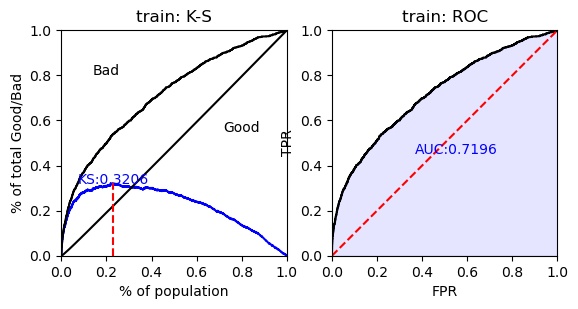

/home/ZXCVQ/.conda/envs/ING-den/lib/python3.12/site-packages/scorecardpy/condition_fun.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dat.loc[:,y] = dat[y].apply(lambda x: x if pd.isnull(x) else int(x)) #dat[y].astype(int)


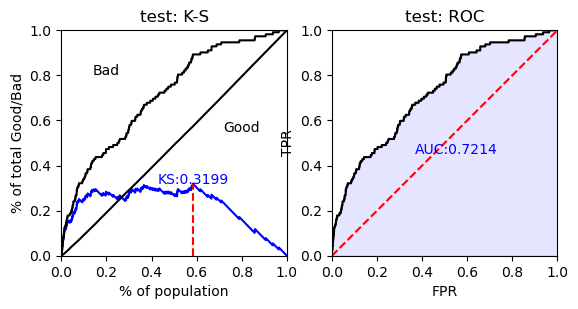

In [15]:
train_perf = sc.perf_eva(y_train, train_proba, title = "train")
test_perf = sc.perf_eva(y_test, test_proba, title = "test")

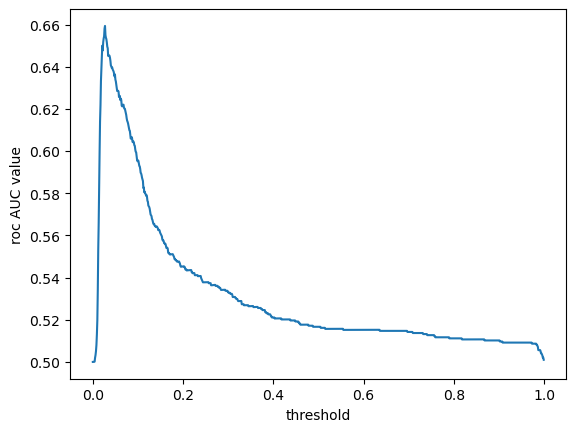

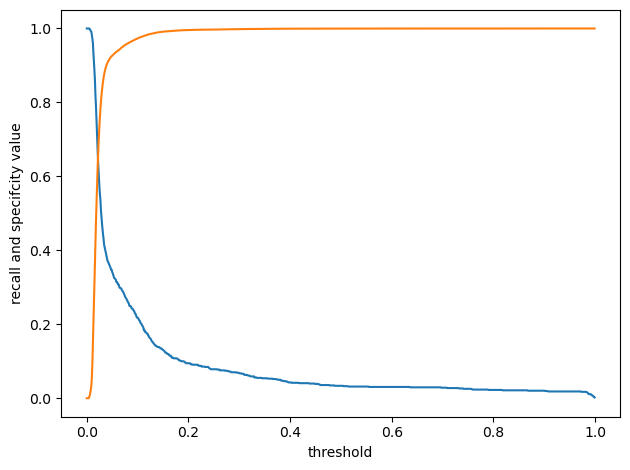

best threshold and its auc is: 0.027 0.6593384680654746


In [16]:
threshold, threshold_auc = find_best_threshold( y_train, train_proba)
print("best threshold and its auc is:",threshold, threshold_auc)

In [17]:
# calculated with default threshold to show
evaluate_model(model, x_train_transformed, y_train, x_test_transformed, y_test, threshold=0.5)

Evaluating model: LogisticRegression


/home/ZXCVQ/.conda/envs/ING-den/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Dataset,AUC,Accuracy,Precision,Recall,F1-score
0,LogisticRegression,Train,0.719565,0.973451,0.767442,0.033605,0.06439
1,LogisticRegression,Test,0.721367,0.968941,0.000000,0.000000,0.00000


In [18]:
# calculated with our selected threshold to show
evaluate_model(model, x_train_transformed, y_train, x_test_transformed, y_test, threshold=threshold)

Evaluating model: LogisticRegression


,Model,Dataset,AUC,Accuracy,Precision,Recall,F1-score
0,LogisticRegression,Train,0.719565,0.780162,0.065226,0.531568,0.116194
1,LogisticRegression,Test,0.721367,0.760954,0.063953,0.491071,0.113169


Evaluating model: LogisticRegression


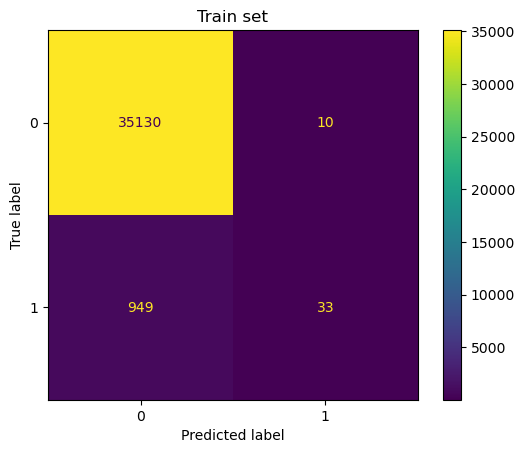

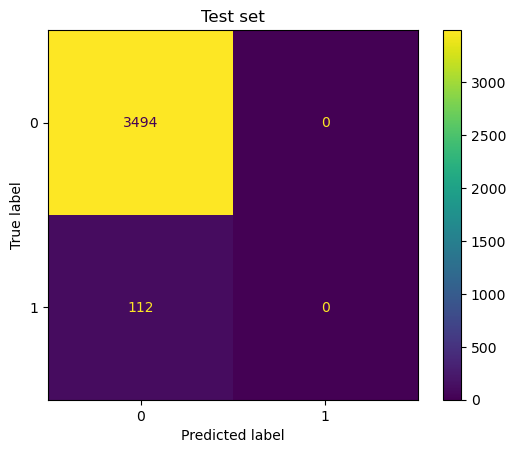

In [19]:
# calculated with default threshold to show. As we can see our model for test data clasifies all observations as not defaulting
confusion_matrices(model, x_train_transformed, y_train, x_test_transformed, y_test, threshold=0.5)

Evaluating model: LogisticRegression


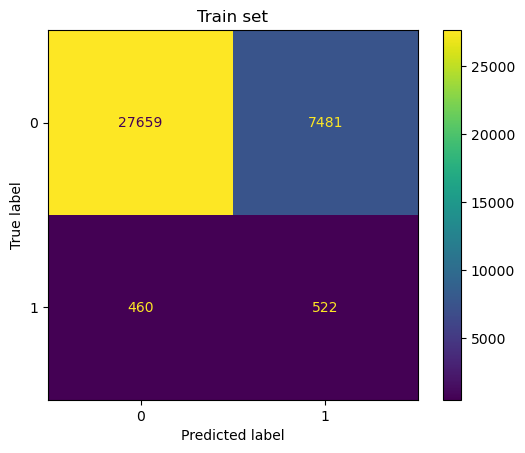

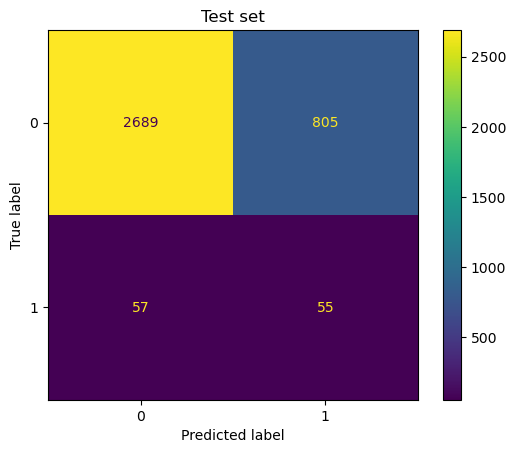

In [20]:
# calculated with our selected threshold to show
confusion_matrices(model, x_train_transformed, y_train, x_test_transformed, y_test, threshold=threshold)

In [21]:
"""
x_train_transformed.to_pickle("./Intermidiate_data/x_train_logistic.pk")
y_train.to_pickle("./Intermidiate_data/y_train_logistic.pk")
x_train_transformed.to_pickle("./Intermidiate_data/x_test_logistic.pk")
y_test.to_pickle("./Intermidiate_data/y_test_logistic.pk")

with open("./Intermidiate_data/model_logistic.pk", 'wb') as f:
    pickle.dump(pipe.steps[-1][1], f)
"""

'\nx_train_transformed.to_pickle("./Intermidiate_data/x_train_logistic.pk")\ny_train.to_pickle("./Intermidiate_data/y_train_logistic.pk")\nx_train_transformed.to_pickle("./Intermidiate_data/x_test_logistic.pk")\ny_test.to_pickle("./Intermidiate_data/y_test_logistic.pk")\n\nwith open("./Intermidiate_data/model_logistic.pk", \'wb\') as f:\n    pickle.dump(pipe.steps[-1][1], f)\n'